In [104]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [105]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="qwen3:14b",
)

In [106]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool, Tool, StructuredTool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [107]:

# Wikiperdia
def wikipedia(query:str):
    """Tool for Wikipedia use"""
    wikipedia = WikipediaAPIWrapper()
    return wikipedia.run(query)


wikkipedia_tool = StructuredTool.from_function(
    func=wikipedia,
    name="WikipediaTool",
    description="Tool for Wikipediasearch"
)

# Tavily
tavily_tool = TavilySearch(max_results=5)

In [108]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

from typing import Dict, Any

# Function to create a retrieval tool
def make_retrieval_tool_from_text(file: str, name: str, desc: str):
    docs = TextLoader(file, encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, HuggingFaceEmbeddings(model="all-MiniLM-L6-v2"))
    retriever = vs.as_retriever()

    def tool_func(query: str) -> Dict[str, Any]:
        print(f"Using tool: {name}")
        results = retriever.invoke(query)
        content = "\n\n".join([doc.page_content for doc in results])
        metadata = {
            "source": file,            
            "documents_retrieved": len(results),
            "metadata": [doc.metadata for doc in results]
        }
        
        return {"content": content, "metadata": metadata}
    
    return Tool(
        name=name,
        description=desc,
        func=tool_func
    )


internal_tool_1 = make_retrieval_tool_from_text(
    "research_notes.txt",
    name="InternalResearchNotes",
    desc="Search internal research notes for experimental results"
)
    

In [109]:
internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retrieval_tool_from_text.<locals>.tool_func at 0x7c38fd3300e0>)

In [110]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessagesState
from langchain.agents import create_agent
from langgraph.types import Command

def get_next_node(last_messsae: BaseMessage, goto: str):
    """"""
    if "FINAL ANSWER" in last_messsae.content:
        # Any Agent decide the work is done
        return END
    return goto

In [111]:
def make_system_prompt(suffix:str) -> str:
    return (f"""
        You are a helpful AI Assistant, collaborating wiith other assistants.
        Use the provided tools to progress towards answering the question.
        If you are unable to fully answer, that's OK, another assistant with different tools
        will help where you left off. Execute what you can to make progress.
        If you or any of the other assistants have the final answer or deliverable,
        prefix your response with FINAL ANSWER so the tram knows to stop.
        You are not allowed to use any symbols or icons.
        \n{suffix}
    """)

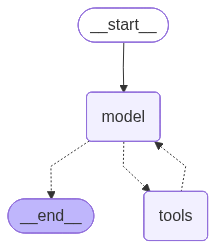

In [112]:
### Research Agent and Node

research_agent = create_agent(
    model=llm,
    tools=[internal_tool_1, tavily_tool],
    system_prompt=make_system_prompt("you can only do research. Use the tools you are binded with. You can use both of them. You are working with a content writer colleague."),
    name="research_agent"
)

research_agent

In [113]:
from typing import Literal

### Research Node
def research_node(state: MessagesState) -> Command[Literal["blog_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result['messages'][-1], "blog_generator")
    
    # Wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result['messages'][-1].content, name="researcher"
    )
    
    return Command(
        update={
            "messages": result['messages']
        },
        goto=goto
    )       

In [114]:
### Blog write agent
blog_agent = create_agent(
    model=llm,
    tools=[],
    system_prompt=make_system_prompt("""
        You can only write a detailed blog. You are working with a researcher colleague.                       
    """),
    name="blog_agent"
)

In [115]:
### Blog Node
def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = blog_agent.invoke(state)
    goto = get_next_node(result['messages'][-1], "researcher")
    
    # Wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result['messages'][-1].content, name="blog_generator"
    )
    
    return Command(
        update={
            "messages": result['messages']
        },
        goto=goto
    )     

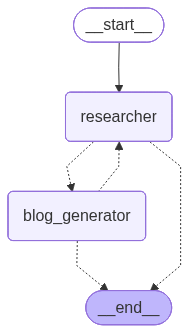

In [116]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("blog_generator", blog_node)

workflow.add_edge(START, "researcher")

graph = workflow.compile()
graph

In [117]:
def add(a: float, b: float):
    """Add two numbers"""
    return a + b

def multiply(a: float, b: float):
    """Multiply two numbers"""
    return a * b

def divide(a: float, b: float):
    """Devide two numbers"""
    return a / b

def subtract(a: float, b: float):
    """Subtract two numbers"""
    return a - b

In [118]:
math_agent = create_agent(
    llm,
    tools=[add, multiply, divide, subtract],
    system_prompt="""
        You are a math agent.\n\n
        
        INSTRUCITONS:
        - Assist ONLY with math-related tasks\n
        - After your're done with your tasks, respond, th the supervisor idrectly\n
        - Respond ONLY with the results of your work, do NOT includ ANY other text.
    """,
    name="math_Agent"
)

In [123]:
from langgraph_supervisor import create_supervisor

supervisor = create_supervisor(
    agents=[math_agent, blog_agent, research_agent],
    model=llm,
    prompt=(
        """
        You are a supervisor managing three agents.\n
        - a research agent. Assign research-related tasks to this agent.\n
        - a blog agent. Assign blog writing tasks to this agent.\n
        - a math agent. Assign math-related tasks to this agent.\n
        Assign work to one agent at a time, do not call agents in parallel.\n
        Do not do any work yourself
        """
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
    supervisor_name="supervisor_agent"
).compile()

In [124]:
response=supervisor.invoke({"messages": "list all the transformer variants in production deployments from the retriever and then tell me what is 5 plus 10"})

In [125]:
from IPython.display import Markdown

Markdown(response["messages"][-1].content)

Here's the information you requested:

**Transformer Variants in Production Deployments:**
- **ALBERT** (A Lite BERT): A lightweight BERT variant with reduced parameters.
- **DistilBERT**: A smaller, faster BERT variant retaining most performance.
- **Encoder-Decoder Transformer**: Used for sequence-to-sequence tasks (e.g., translation).

**Calculation:**  
5 + 10 = **15**.